In [2]:
from PIL import Image
import numpy as np
from skimage import color
from skimage.color import lab2rgb, rgb2lab
import torch
import os
import torch.nn as nn
import torch.nn.functional as F
from IPython import embed
import matplotlib.pyplot as plt

In [3]:
# UTILITY FUNCTIONS

def load_img(img_path):
	out_np = np.asarray(Image.open(img_path))
	if(out_np.ndim==2):
		out_np = np.tile(out_np[:,:,None],3)
	return out_np

def resize_img(img, HW=(256,256), resample=3):
	return np.asarray(Image.fromarray(img).resize((HW[1],HW[0]), resample=resample))

def preprocess_img(img_rgb_orig, HW=(256,256), resample=3):
    # return original size L and resized L as torch Tensors
    img_rgb_rs = resize_img(img_rgb_orig, HW=HW, resample=resample)
    
    img_lab_orig = color.rgb2lab(img_rgb_orig)
    img_lab_rs = color.rgb2lab(img_rgb_rs)

    img_l_orig = img_lab_orig[:, :, 0]
    img_l_rs = img_lab_rs[:, :, 0]
    img_ab_rs = img_lab_rs[:, :, 1:3]

    tens_orig_l = torch.Tensor(img_l_orig)[None, None, :, :]
    tens_rs_l = torch.Tensor(img_l_rs)[None, None, :, :]
    tens_rs_ab = torch.Tensor(img_ab_rs).permute(2, 0, 1)  # (2,H,W)

    return (tens_orig_l, tens_rs_l, tens_rs_ab)

def postprocess_tens(tens_orig_l, out_ab, mode='bilinear'):
	# tens_orig_l 	1 x 1 x H_orig x W_orig
	# out_ab 		1 x 2 x H x W

	HW_orig = tens_orig_l.shape[2:]
	HW = out_ab.shape[2:]

	# call resize function if needed
	if(HW_orig[0]!=HW[0] or HW_orig[1]!=HW[1]):
		out_ab_orig = F.interpolate(out_ab, size=HW_orig, mode='bilinear')
	else:
		out_ab_orig = out_ab

	out_lab_orig = torch.cat((tens_orig_l, out_ab_orig), dim=1)
	return color.lab2rgb(out_lab_orig.data.cpu().numpy()[0,...].transpose((1,2,0)))

def compute_soft_encoding(ab_image, bin_centers, sigma=5.0):
    """
    ab_image: Tensor of shape [2, H, W] (ground truth ab channels)
    bin_centers: Tensor of shape [313, 2] (predefined bin centers)
    sigma: Soft-encoding standard deviation
    Returns:
        soft_encoding: Tensor of shape [313, H, W]
    """
    C, H, W = ab_image.shape
    ab_flat = ab_image.view(2, -1).T  # [H*W, 2]

    # Compute L2 distance from each pixel to each bin center
    dist = torch.cdist(ab_flat.unsqueeze(0), bin_centers.unsqueeze(0)).squeeze(0)  # [H*W, 313]

    # Apply softmax with negative distances to get soft-assignment
    weights = torch.exp(- (dist ** 2) / (2 * sigma ** 2))  # Gaussian kernel
    weights = weights / weights.sum(dim=1, keepdim=True)  # Normalize to sum to 1
    soft_encoding = weights.T.view(313, H, W)
    return soft_encoding


## Bin centers

bin_centers = torch.zeros(313, 2)

ab_idx2bin_idx = {
    (0, 16): 0, (0, 17): 1, (0, 18): 2, (0, 19): 3, (0, 20): 4,
    (1, 13): 5, (1, 14): 6, (1, 15): 7, (1, 16): 8, (1, 17): 9, (1, 18): 10, (1, 19): 11, (1, 20): 12,
    (2, 11): 13, (2, 12): 14, (2, 13): 15, (2, 14): 16, (2, 15): 17, (2, 16): 18, (2, 17): 19, (2, 18): 20, (2, 19): 21, (2, 20): 22,
    (3, 9): 23, (3, 10): 24, (3, 11): 25, (3, 12): 26, (3, 13): 27, (3, 14): 28, (3, 15): 29, (3, 16): 30, (3, 17): 31, (3, 18): 32, (3, 19): 33, (3, 20): 34,
    (4, 8): 35, (4, 9): 36, (4, 10): 37, (4, 11): 38, (4, 12): 39, (4, 13): 40, (4, 14): 41, (4, 15): 42, (4, 16): 43, (4, 17): 44, (4, 18): 45, (4, 19): 46, (4, 20): 47, (4, 21): 48,
    (5, 7): 49, (5, 8): 50, (5, 9): 51, (5, 10): 52, (5, 11): 53, (5, 12): 54, (5, 13): 55, (5, 14): 56, (5, 15): 57, (5, 16): 58, (5, 17): 59, (5, 18): 60, (5, 19): 61, (5, 20): 62, (5, 21): 63,
    (6, 6): 64, (6, 7): 65, (6, 8): 66, (6, 9): 67, (6, 10): 68, (6, 11): 69, (6, 12): 70, (6, 13): 71, (6, 14): 72, (6, 15): 73, (6, 16): 74, (6, 17): 75, (6, 18): 76, (6, 19): 77, (6, 20): 78, (6, 21): 79,
    (7, 6): 80, (7, 7): 81, (7, 8): 82, (7, 9): 83, (7, 10): 84, (7, 11): 85, (7, 12): 86, (7, 13): 87, (7, 14): 88, (7, 15): 89, (7, 16): 90, (7, 17): 91, (7, 18): 92, (7, 19): 93, (7, 20): 94, (7, 21): 95,
    (8, 5): 96, (8, 6): 97, (8, 7): 98, (8, 8): 99, (8, 9): 100, (8, 10): 101, (8, 11): 102, (8, 12): 103, (8, 13): 104, (8, 14): 105, (8, 15): 106, (8, 16): 107, (8, 17): 108, (8, 18): 109, (8, 19): 110, (8, 20): 111, (8, 21): 112,
    (9, 4): 113, (9, 5): 114, (9, 6): 115, (9, 7): 116, (9, 8): 117, (9, 9): 118, (9, 10): 119, (9, 11): 120, (9, 12): 121, (9, 13): 122, (9, 14): 123, (9, 15): 124, (9, 16): 125, (9, 17): 126, (9, 18): 127, (9, 19): 128, (9, 20): 129, (9, 21): 130,
    (10, 3): 131, (10, 4): 132, (10, 5): 133, (10, 6): 134, (10, 7): 135, (10, 8): 136, (10, 9): 137, (10, 10): 138, (10, 11): 139, (10, 12): 140, (10, 13): 141, (10, 14): 142, (10, 15): 143, (10, 16): 144, (10, 17): 145, (10, 18): 146, (10, 19): 147, (10, 20): 148,
    (11, 3): 149, (11, 4): 150, (11, 5): 151, (11, 6): 152, (11, 7): 153, (11, 8): 153, (11, 9): 155, (11, 10): 156, (11, 11): 157, (11, 12): 158, (11, 13): 159, (11, 14): 160, (11, 15): 161, (11, 16): 162, (11, 17): 163, (11, 18): 164, (11, 19): 165, (11, 20): 166,
    (12, 2): 167, (12, 3): 168, (12, 4): 169, (12, 5): 170, (12, 6): 171, (12, 7): 172, (12, 8): 173, (12, 9): 174, (12, 10): 175, (12, 11): 176, (12, 12): 177, (12, 13): 178, (12, 14): 179, (12, 15): 180, (12, 16): 181, (12, 17): 182, (12, 18): 183, (12, 19): 184, (12, 20): 185,
    (13, 1): 186, (13, 2): 187, (13, 3): 188, (13, 4): 189, (13, 5): 190, (13, 6): 191, (13, 7): 192, (13, 8): 193, (13, 9): 194, (13, 10): 195, (13, 11): 196, (13, 12): 197, (13, 13): 198, (13, 14): 199, (13, 15): 200, (13, 16): 201, (13, 17): 202, (13, 18): 203, (13, 19): 204, (13, 20): 205,
    (14, 1): 206, (14, 2): 207, (14, 3): 208, (14, 4): 209, (14, 5): 210, (14, 6): 211, (14, 7): 212, (14, 8): 213, (14, 9): 214, (14, 10): 215, (14, 11): 216, (14, 12): 217, (14, 13): 218, (14, 14): 219, (14, 15): 220, (14, 16): 221, (14, 17): 222, (14, 18): 223, (14, 19): 224,
    (15, 0): 225, (15, 1): 226, (15, 2): 227, (15, 3): 228, (15, 4): 229, (15, 5): 230, (15, 6): 231, (15, 7): 232, (15, 8): 233, (15, 9): 234, (15, 10): 235, (15, 11): 236, (15, 12): 237, (15, 13): 238, (15, 14): 239, (15, 15): 240, (15, 16): 241, (15, 17): 242, (15, 18): 243, (15, 19): 244,
    (16, 0): 245, (16, 1): 246, (16, 2): 247, (16, 3): 248, (16, 4): 249, (16, 5): 250, (16, 6): 251, (16, 7): 252, (16, 8): 253, (16, 9): 254, (16, 10): 255, (16, 11): 256, (16, 12): 257, (16, 13): 258, (16, 14): 259, (16, 15): 260, (16, 16): 261, (16, 17): 262, (16, 18): 263, (16, 19): 264,
    (17, 0): 265, (17, 1): 266, (17, 2): 267, (17, 3): 268, (17, 4): 269, (17, 5): 270, (17, 6): 271, (17, 7): 272, (17, 8): 273, (17, 9): 274, (17, 10): 275, (17, 11): 276, (17, 12): 277, (17, 13): 278, (17, 14): 279, (17, 15): 280, (17, 16): 281, (17, 17): 282, (17, 18): 283,
    (18, 0): 284, (18, 1): 285, (18, 2): 286, (18, 3): 287, (18, 4): 288, (18, 5): 289, (18, 6): 290, (18, 7): 291, (18, 8): 292, (18, 9): 293, (18, 10): 294, (18, 11): 295, (18, 12): 296, (18, 13): 297, (18, 14): 298, (18, 15): 299, (18, 16): 300, (18, 17): 301, (18, 18): 302,
    (19, 2): 303, (19, 3): 304, (19, 4): 305, (19, 5): 306, (19, 6): 307, (19, 7): 308, (19, 8): 309, (19, 9): 310, (19, 10): 311, (19, 11): 312
}
for (a_idx, b_idx), bin_idx in ab_idx2bin_idx.items():
    a = -90 + 10 * a_idx
    b = -110 + 10 * b_idx
    bin_centers[bin_idx] = torch.tensor([a, b]) 

In [4]:
class Colorization(nn.Module):
    def __init__(self):
        super(Colorization, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),
            
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),
            
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),
            
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),
            
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            
            nn.Conv2d(in_channels=256, out_channels=313, kernel_size=1, stride=1, padding=0),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(313)
        )

    def forward(self, x):
        return self.model(x)

In [5]:
print('loading bin probs')
bin_probs = torch.load('/kaggle/input/bin-probabilities/bin_probs_large.pt',weights_only=True)
print(bin_probs.shape)

loading bin probs
torch.Size([313])


In [6]:
## Bin Probabilities
p = (bin_probs*1000 +2)/(bin_probs*1000 +2).sum()
lambda_val = 0.5
Q = 313
p = p + 1e-8  # avoid division by zero
w = 1.0 / ((1 - lambda_val) * p + (lambda_val / Q))
w = w / (w * p).sum()  # normalize so E[w] = 1
print("exp_w ",sum(w*p)/sum(p))
print(torch.min(w), torch.max(w))  # Check for extreme values in weights

exp_w  tensor(1.0000)
tensor(0.0449) tensor(2.0587)


In [ ]:
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class ColorizationDataset(Dataset):
    def __init__(self, root_dir, bin_centers, HW=(256, 256)):
        self.root_dir = root_dir
        self.image_paths = []
        self.HW = HW
        self.bin_centers = bin_centers
        
        dirs = ['00000', '00001', '00002', '00003', '00004', '00005', '00006', '00007', '00008', '00009']
        for class_folder in dirs[:10]:
            class_path = os.path.join(root_dir, class_folder)
            for _, _, files in os.walk(class_path):
                for file in files:
                    self.image_paths.append(os.path.join(class_path, file))
            print(len(self.image_paths))
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        
        img_rgb_orig = load_img(img_path)              # your utility function
        img_rgb_rs = resize_img(img_rgb_orig, self.HW)  # your utility function

        tens_orig_l, tens_rs_l, tens_rs_ab = preprocess_img(img_rgb_rs, HW=self.HW)  # modified to return ab too

        # Compute target z
        ab_image_down = F.interpolate(tens_rs_ab.unsqueeze(0), size=(64, 64), mode='bilinear', align_corners=False).squeeze(0)
        z = compute_soft_encoding(ab_image_down, self.bin_centers)  # shape (313, 64, 64)

        return tens_rs_l.squeeze(0), z


In [ ]:
# Dataset instance
print('making dataset')
train_dataset = ColorizationDataset(
    root_dir='/kaggle/input/imagenet1k0',   # change to your train folder
    bin_centers=bin_centers,
    HW=(256, 256)
)
print('making dataloader')
# DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)

In [ ]:
import torch.nn as nn
import torch.optim as optim

# Model
model = Colorization()
model.load_state_dict(torch.load('/kaggle/input/bin-probabilities/colorization_model_20epochs.pth'))
model = model.cuda()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-2)

# Loss
def colorization_loss(z_hat, z, w):
    # z_hat: (B, 313, 64, 64)
    # z: (B, 313, 64, 64)
    weights_per_pixel = (z * w[:, None, None]).sum(dim=1)  # (B, 64, 64)
    ce_loss = -(z * torch.log(z_hat + 1e-8)).sum(dim=1)    # (B, 64, 64)
    weighted_loss = (weights_per_pixel * ce_loss).mean()
    return weighted_loss

print('start training...')
# Training
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    print(len(train_loader))
    for batch_idx, (tens_rs_l, z) in enumerate(train_loader):
        tens_rs_l = tens_rs_l.cuda()        # (B, 1, 256, 256)
        z = z.cuda()                        # (B, 313, 64, 64)

        optimizer.zero_grad()
        z_hat = model(tens_rs_l)             # (B, 313, 64, 64)
        z_hat = torch.softmax(z_hat, dim=1)  # Softmax over class dimension

        loss = colorization_loss(z_hat, z, w.cuda())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if batch_idx%10==0:
            print(f"{batch_idx} has loss {loss.item()}")

    avg_loss = running_loss / len(train_loader)
    print(f"\n\nEpoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.6f}\n")

print('saving model')
torch.save(model.state_dict(), '/kaggle/working/colorization_model_40kaggle.pth',)

In [ ]:
print('saving model again')
torch.save(model.state_dict(), '/kaggle/working/colorization_model_40kaggle_same.pth')

torch.Size([1, 313, 64, 64])


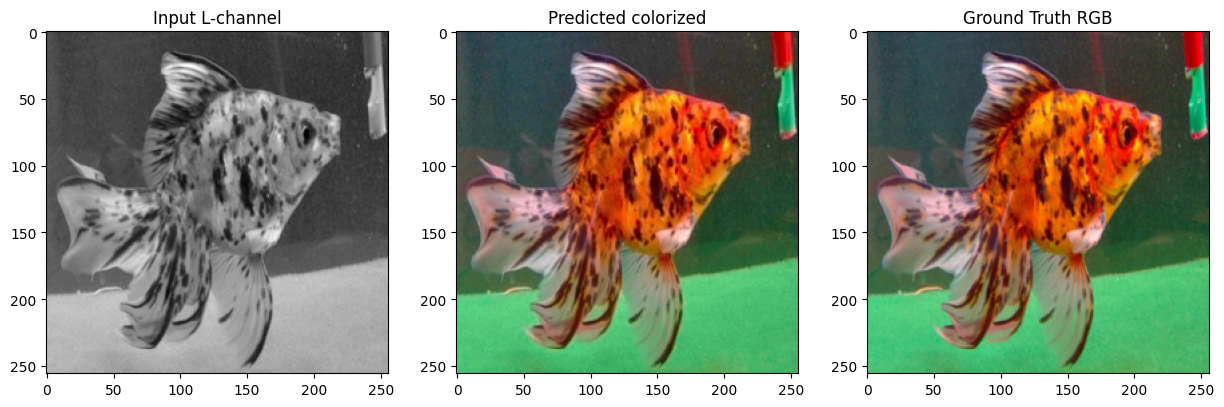

In [11]:
'''
img_path = '/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/train/n01440764/n01440764_10028.JPEG'
img_path = '/kaggle/input/imagenet1k0/00001/0027312677195264.jpg'

img_rgb_orig = load_img(img_path)
img_rgb_rs = resize_img(img_rgb_orig, HW=(256, 256))
_, tens_rs_l,tens_rs_ab = preprocess_img(img_rgb_rs, HW=(256, 256))
ab_image_down = F.interpolate(tens_rs_ab.unsqueeze(0), size=(64, 64), mode='bilinear', align_corners=False).squeeze(0)
z_hat = compute_soft_encoding(ab_image_down, bin_centers)
z_hat = z_hat.unsqueeze(0)
print(z_hat.shape)
# Forward
# Temperature sharpening
T = 0.38
z_hat_T = torch.pow(z_hat, 1.0 / T)
z_hat_T = z_hat_T / z_hat_T.sum(dim=1, keepdim=True)
pred_ab = torch.einsum('ncxy,cd->ndxy', z_hat_T.cuda(), bin_centers.cuda())

# Upsample
pred_ab_upsampled = F.interpolate(pred_ab, size=(256, 256), mode='bilinear', align_corners=False)

# LAB fusion
out_lab = torch.cat((tens_rs_l.cuda(), pred_ab_upsampled.cuda()), dim=1)

# LAB -> RGB
out_rgb = postprocess_tens(tens_rs_l.cuda(), pred_ab_upsampled.cuda())
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.title('Input L-channel')
plt.imshow(tens_rs_l.cpu().numpy()[0,0], cmap='gray')

# Show predicted color image
plt.subplot(1,3,2)
plt.title('Predicted colorized')
plt.imshow(out_rgb)

# Show ground truth RGB
plt.subplot(1,3,3)
plt.title('Ground Truth RGB')
plt.imshow(img_rgb_rs)

plt.show()
'''

## WORKING WITH THE IMAGES 

In [ ]:
from PIL import Image
import numpy as np
from skimage import color
from skimage.color import lab2rgb, rgb2lab
import torch
import os
import torch.nn as nn
import torch.nn.functional as F
from IPython import embed
import matplotlib.pyplot as plt

In [ ]:
# UTILITY FUNCTIONS

def load_img(img_path):
	out_np = np.asarray(Image.open(img_path))
	if(out_np.ndim==2):
		out_np = np.tile(out_np[:,:,None],3)
	return out_np

def resize_img(img, HW=(256,256), resample=3):
	return np.asarray(Image.fromarray(img).resize((HW[1],HW[0]), resample=resample))

def preprocess_img(img_rgb_orig, HW=(256,256), resample=3):
    # return original size L and resized L as torch Tensors
    img_rgb_rs = resize_img(img_rgb_orig, HW=HW, resample=resample)
    
    img_lab_orig = color.rgb2lab(img_rgb_orig)
    img_lab_rs = color.rgb2lab(img_rgb_rs)

    img_l_orig = img_lab_orig[:, :, 0]
    img_l_rs = img_lab_rs[:, :, 0]
    img_ab_rs = img_lab_rs[:, :, 1:3]

    tens_orig_l = torch.Tensor(img_l_orig)[None, None, :, :]
    tens_rs_l = torch.Tensor(img_l_rs)[None, None, :, :]
    tens_rs_ab = torch.Tensor(img_ab_rs).permute(2, 0, 1)  # (2,H,W)

    return (tens_orig_l, tens_rs_l, tens_rs_ab)

def postprocess_tens(tens_orig_l, out_ab, mode='bilinear'):
	# tens_orig_l 	1 x 1 x H_orig x W_orig
	# out_ab 		1 x 2 x H x W

	HW_orig = tens_orig_l.shape[2:]
	HW = out_ab.shape[2:]

	# call resize function if needed
	if(HW_orig[0]!=HW[0] or HW_orig[1]!=HW[1]):
		out_ab_orig = F.interpolate(out_ab, size=HW_orig, mode='bilinear')
	else:
		out_ab_orig = out_ab

	out_lab_orig = torch.cat((tens_orig_l, out_ab_orig), dim=1)
	return color.lab2rgb(out_lab_orig.data.cpu().numpy()[0,...].transpose((1,2,0)))

def compute_soft_encoding(ab_image, bin_centers, sigma=5.0):
    """
    ab_image: Tensor of shape [2, H, W] (ground truth ab channels)
    bin_centers: Tensor of shape [313, 2] (predefined bin centers)
    sigma: Soft-encoding standard deviation
    Returns:
        soft_encoding: Tensor of shape [313, H, W]
    """
    C, H, W = ab_image.shape
    ab_flat = ab_image.view(2, -1).T  # [H*W, 2]

    # Compute L2 distance from each pixel to each bin center
    dist = torch.cdist(ab_flat.unsqueeze(0), bin_centers.unsqueeze(0)).squeeze(0)  # [H*W, 313]

    # Apply softmax with negative distances to get soft-assignment
    weights = torch.exp(- (dist ** 2) / (2 * sigma ** 2))  # Gaussian kernel
    weights = weights / weights.sum(dim=1, keepdim=True)  # Normalize to sum to 1
    soft_encoding = weights.T.view(313, H, W)
    return soft_encoding

In [ ]:

'''img_path = '/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/train/n01443537/n01443537_10014.JPEG'

img_rgb_orig = load_img(img_path)
img_rgb_rs = resize_img(img_rgb_orig, HW=(256, 256))
tens_orig_l, tens_rs_l,tens_rs_ab = preprocess_img(img_rgb_rs, HW=(256, 256))

plt.figure(figsize=(3,3))
plt.title("Original Image")
plt.imshow(img_rgb_orig)
plt.show()

print("Original image shape:", img_rgb_orig.shape)
print("Resized image shape :", img_rgb_rs.shape)

plt.figure(figsize=(3,3))
plt.title("Resized Image (256x256)")
plt.imshow(img_rgb_rs)
plt.show()

plt.figure(figsize=(3,3))
plt.title("Resized L Channel (Lightness)")
plt.imshow(tens_rs_l[0,0,:,:], cmap='gray')
plt.show()
'''

## ARCHITECTURE

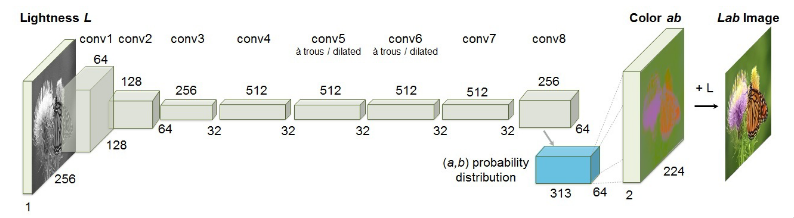

```txt
Input (1x256x256)
    ↓ Conv1 (stride 2)
64x128x128
    ↓ Conv2 (stride 2)
128x64x64
    ↓ Conv3 (stride 2)
256x32x32
    ↓ Conv4
512x32x32
    ↓ Conv5 (dilated)
512x32x32
    ↓ Conv6 (dilated)
512x32x32
    ↓ Conv7
512x32x32
    ↓ Conv8 (transpose conv stride 2)
256x64x64
    ↓ Conv9 (1x1 conv)
313x64x64
    ↓ Softmax
Distribution (64x64x313)
    ↓ Annealed Mean
Predicted (a,b) at 64x64
    ↓ Bilinear Upsampling
(a,b) at 224x224
    ↓ Concatenate with L
Lab image (224x224)
```

In [ ]:
class Colorization(nn.Module):
    def __init__(self):
        super(Colorization, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),
            
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),
            
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),
            
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),
            
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            
            nn.Conv2d(in_channels=256, out_channels=313, kernel_size=1, stride=1, padding=0),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(313)
        )

    def forward(self, x):
        return self.model(x)


In [ ]:
#print(tens_rs_l.shape)
#ConvModule = Colorization()
#z = ConvModule(tens_rs_l)
#print(z.shape)

In [ ]:
## Bin centers
'''
bin_centers = torch.zeros(313, 2)

ab_idx2bin_idx = {
    (0, 16): 0, (0, 17): 1, (0, 18): 2, (0, 19): 3, (0, 20): 4,
    (1, 13): 5, (1, 14): 6, (1, 15): 7, (1, 16): 8, (1, 17): 9, (1, 18): 10, (1, 19): 11, (1, 20): 12,
    (2, 11): 13, (2, 12): 14, (2, 13): 15, (2, 14): 16, (2, 15): 17, (2, 16): 18, (2, 17): 19, (2, 18): 20, (2, 19): 21, (2, 20): 22,
    (3, 9): 23, (3, 10): 24, (3, 11): 25, (3, 12): 26, (3, 13): 27, (3, 14): 28, (3, 15): 29, (3, 16): 30, (3, 17): 31, (3, 18): 32, (3, 19): 33, (3, 20): 34,
    (4, 8): 35, (4, 9): 36, (4, 10): 37, (4, 11): 38, (4, 12): 39, (4, 13): 40, (4, 14): 41, (4, 15): 42, (4, 16): 43, (4, 17): 44, (4, 18): 45, (4, 19): 46, (4, 20): 47, (4, 21): 48,
    (5, 7): 49, (5, 8): 50, (5, 9): 51, (5, 10): 52, (5, 11): 53, (5, 12): 54, (5, 13): 55, (5, 14): 56, (5, 15): 57, (5, 16): 58, (5, 17): 59, (5, 18): 60, (5, 19): 61, (5, 20): 62, (5, 21): 63,
    (6, 6): 64, (6, 7): 65, (6, 8): 66, (6, 9): 67, (6, 10): 68, (6, 11): 69, (6, 12): 70, (6, 13): 71, (6, 14): 72, (6, 15): 73, (6, 16): 74, (6, 17): 75, (6, 18): 76, (6, 19): 77, (6, 20): 78, (6, 21): 79,
    (7, 6): 80, (7, 7): 81, (7, 8): 82, (7, 9): 83, (7, 10): 84, (7, 11): 85, (7, 12): 86, (7, 13): 87, (7, 14): 88, (7, 15): 89, (7, 16): 90, (7, 17): 91, (7, 18): 92, (7, 19): 93, (7, 20): 94, (7, 21): 95,
    (8, 5): 96, (8, 6): 97, (8, 7): 98, (8, 8): 99, (8, 9): 100, (8, 10): 101, (8, 11): 102, (8, 12): 103, (8, 13): 104, (8, 14): 105, (8, 15): 106, (8, 16): 107, (8, 17): 108, (8, 18): 109, (8, 19): 110, (8, 20): 111, (8, 21): 112,
    (9, 4): 113, (9, 5): 114, (9, 6): 115, (9, 7): 116, (9, 8): 117, (9, 9): 118, (9, 10): 119, (9, 11): 120, (9, 12): 121, (9, 13): 122, (9, 14): 123, (9, 15): 124, (9, 16): 125, (9, 17): 126, (9, 18): 127, (9, 19): 128, (9, 20): 129, (9, 21): 130,
    (10, 3): 131, (10, 4): 132, (10, 5): 133, (10, 6): 134, (10, 7): 135, (10, 8): 136, (10, 9): 137, (10, 10): 138, (10, 11): 139, (10, 12): 140, (10, 13): 141, (10, 14): 142, (10, 15): 143, (10, 16): 144, (10, 17): 145, (10, 18): 146, (10, 19): 147, (10, 20): 148,
    (11, 3): 149, (11, 4): 150, (11, 5): 151, (11, 6): 152, (11, 7): 153, (11, 8): 153, (11, 9): 155, (11, 10): 156, (11, 11): 157, (11, 12): 158, (11, 13): 159, (11, 14): 160, (11, 15): 161, (11, 16): 162, (11, 17): 163, (11, 18): 164, (11, 19): 165, (11, 20): 166,
    (12, 2): 167, (12, 3): 168, (12, 4): 169, (12, 5): 170, (12, 6): 171, (12, 7): 172, (12, 8): 173, (12, 9): 174, (12, 10): 175, (12, 11): 176, (12, 12): 177, (12, 13): 178, (12, 14): 179, (12, 15): 180, (12, 16): 181, (12, 17): 182, (12, 18): 183, (12, 19): 184, (12, 20): 185,
    (13, 1): 186, (13, 2): 187, (13, 3): 188, (13, 4): 189, (13, 5): 190, (13, 6): 191, (13, 7): 192, (13, 8): 193, (13, 9): 194, (13, 10): 195, (13, 11): 196, (13, 12): 197, (13, 13): 198, (13, 14): 199, (13, 15): 200, (13, 16): 201, (13, 17): 202, (13, 18): 203, (13, 19): 204, (13, 20): 205,
    (14, 1): 206, (14, 2): 207, (14, 3): 208, (14, 4): 209, (14, 5): 210, (14, 6): 211, (14, 7): 212, (14, 8): 213, (14, 9): 214, (14, 10): 215, (14, 11): 216, (14, 12): 217, (14, 13): 218, (14, 14): 219, (14, 15): 220, (14, 16): 221, (14, 17): 222, (14, 18): 223, (14, 19): 224,
    (15, 0): 225, (15, 1): 226, (15, 2): 227, (15, 3): 228, (15, 4): 229, (15, 5): 230, (15, 6): 231, (15, 7): 232, (15, 8): 233, (15, 9): 234, (15, 10): 235, (15, 11): 236, (15, 12): 237, (15, 13): 238, (15, 14): 239, (15, 15): 240, (15, 16): 241, (15, 17): 242, (15, 18): 243, (15, 19): 244,
    (16, 0): 245, (16, 1): 246, (16, 2): 247, (16, 3): 248, (16, 4): 249, (16, 5): 250, (16, 6): 251, (16, 7): 252, (16, 8): 253, (16, 9): 254, (16, 10): 255, (16, 11): 256, (16, 12): 257, (16, 13): 258, (16, 14): 259, (16, 15): 260, (16, 16): 261, (16, 17): 262, (16, 18): 263, (16, 19): 264,
    (17, 0): 265, (17, 1): 266, (17, 2): 267, (17, 3): 268, (17, 4): 269, (17, 5): 270, (17, 6): 271, (17, 7): 272, (17, 8): 273, (17, 9): 274, (17, 10): 275, (17, 11): 276, (17, 12): 277, (17, 13): 278, (17, 14): 279, (17, 15): 280, (17, 16): 281, (17, 17): 282, (17, 18): 283,
    (18, 0): 284, (18, 1): 285, (18, 2): 286, (18, 3): 287, (18, 4): 288, (18, 5): 289, (18, 6): 290, (18, 7): 291, (18, 8): 292, (18, 9): 293, (18, 10): 294, (18, 11): 295, (18, 12): 296, (18, 13): 297, (18, 14): 298, (18, 15): 299, (18, 16): 300, (18, 17): 301, (18, 18): 302,
    (19, 2): 303, (19, 3): 304, (19, 4): 305, (19, 5): 306, (19, 6): 307, (19, 7): 308, (19, 8): 309, (19, 9): 310, (19, 10): 311, (19, 11): 312
}
for (a_idx, b_idx), bin_idx in ab_idx2bin_idx.items():
    a = -90 + 10 * a_idx
    b = -110 + 10 * b_idx
    bin_centers[bin_idx] = torch.tensor([a, b]) 
    '''

In [ ]:
def compute_soft_encoding(ab_image, bin_centers, sigma=5.0):
    """
    ab_image: Tensor of shape [2, H, W] (ground truth ab channels)
    bin_centers: Tensor of shape [313, 2] (predefined bin centers)
    sigma: Soft-encoding standard deviation
    Returns:
        soft_encoding: Tensor of shape [313, H, W]
    """
    C, H, W = ab_image.shape
    ab_flat = ab_image.view(2, -1).T  # [H*W, 2]

    # Compute L2 distance from each pixel to each bin center
    dist = torch.cdist(ab_flat.unsqueeze(0), bin_centers.unsqueeze(0)).squeeze(0)  # [H*W, 313]

    # Apply softmax with negative distances to get soft-assignment
    weights = torch.exp(- (dist ** 2) / (2 * sigma ** 2))  # Gaussian kernel
    weights = weights / weights.sum(dim=1, keepdim=True)  # Normalize to sum to 1
    soft_encoding = weights.T.view(313, H, W)
    return soft_encoding
'''
ab_image_down = F.interpolate(tens_rs_ab.unsqueeze(0), size=(64, 64), mode='bilinear', align_corners=False).squeeze(0)
tens_rs_l_down = F.interpolate(tens_rs_l, size=(64, 64), mode='bilinear', align_corners=False).squeeze(0)
soft_y = compute_soft_encoding(ab_image_down, bin_centers)

print(soft_y.shape)

lab_image = torch.cat([tens_rs_l_down, ab_image_down], dim=0).cpu().numpy()  # [3, H, W]
lab_image = np.transpose(lab_image, (1, 2, 0))  # [H, W, 3]
rgb_image = lab2rgb(lab_image)
plt.figure(figsize=(4, 4))
plt.imshow(rgb_image)
plt.title('RGB from tens_rs_l and ab_image_down')
plt.show()
'''

In [ ]:
'''
bin_counts = torch.ones(313)

path = '/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/train'

for root, dirs, _ in os.walk(path):
    break 
i = 0
for class_folder in dirs:

    #break 
    
    class_folder = os.path.join(path, class_folder)
    files = os.listdir(class_folder)[:120]  
    i+=1
    for img in files:
        try:
            img_path = os.path.join(class_folder, img)
            img_rgb = load_img(img_path)
            img_rgb_rs = resize_img(img_rgb, HW=(256, 256))
            _, _, tens_rs_ab = preprocess_img(img_rgb_rs, HW=(256, 256))
            ab_image_down = F.interpolate(tens_rs_ab.unsqueeze(0), size=(64, 64), mode='bilinear', align_corners=False).squeeze(0)
            ab_flat = ab_image_down.view(2, -1).T  # [4096, 2]
            dists = torch.cdist(ab_flat.float().unsqueeze(0), bin_centers.float().unsqueeze(0)).squeeze(0)  # [4096, 313]
            hard_indices = torch.argmin(dists, dim=1)  # [4096]
            bin_counts += torch.bincount(hard_indices, minlength=313).cpu()
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
    print("completed ",i ,end= " ")
    
bin_probs = bin_counts / bin_counts.sum()
torch.save(bin_probs, 'bin_probs.pt')
'''

In [ ]:
#bin_probs = (bin_counts + 10) / (bin_counts+10).sum()
#torch.save(bin_probs, 'bin_probs_large.pt')
#bin_probs = torch.load('bin_probs.pt')

In [ ]:
'''
bin_probs = torch.load('bin_probs.pt')
bin_probs_np = bin_probs.numpy()
plt.figure(figsize=(16, 4))
plt.bar(range(313), bin_probs_np, color='skyblue')
plt.xlabel('Bin Index')
plt.ylabel('Probability')
plt.title('Color Bin Probabilities')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

bin_probs_new = (bin_probs*1000 +2)/(bin_probs*1000 +2).sum()
bin_probs_new_np = bin_probs_new.numpy()
plt.figure(figsize=(16, 4))
plt.bar(range(313), bin_probs_new_np, color='skyblue')
plt.xlabel('Bin Index')
plt.ylabel('Probability')
plt.title('Color Bin Probabilities')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
'''

In [ ]:
## Bin Probabilities
'''
p = (bin_probs*1000 +2)/(bin_probs*1000 +2).sum()
lambda_val = 0.5
Q = 313
p = p + 1e-8  # avoid division by zero
w = 1.0 / ((1 - lambda_val) * p + (lambda_val / Q))
w = w / (w * p).sum()  # normalize so E[w] = 1
print("exp_w ",sum(w*p)/sum(p))
print(torch.min(w), torch.max(w))  # Check for extreme values in weights
'''

In [ ]:
'''
w_np = w.numpy()
plt.figure(figsize=(16, 4))
plt.bar(range(313), w_np, color='skyblue')
plt.xlabel('Bin Index')
plt.ylabel('Probability')
plt.title('Color Bin Probabilities')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
'''

In [ ]:
'''
## Image
img_path = '/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/train/n01443537/n01443537_10014.JPEG'
img_rgb_orig = load_img(img_path)
img_rgb_rs = resize_img(img_rgb_orig, HW=(256, 256))
_, tens_rs_l,tens_rs_ab = preprocess_img(img_rgb_rs, HW=(256, 256))

## Convolve to get z hat
print(tens_rs_l.shape)
ConvModule = Colorization()
z_hat = ConvModule(tens_rs_l)
z_hat = torch.softmax(z_hat, dim=1)
print(z_hat.shape)

## Compute target's z
ab_image_down = F.interpolate(tens_rs_ab.unsqueeze(0), size=(64, 64), mode='bilinear', align_corners=False).squeeze(0)
z = compute_soft_encoding(ab_image_down, bin_centers).unsqueeze(0)
print(z.shape)

## rebalane and loss
weights_per_pixel = (z * w[:, None, None]).sum(dim=0) 
log_probs = F.log_softmax(z_hat, dim=1)  # shape (B, 313, 64, 64)
ce_loss = -(z * log_probs).sum(dim=1)  # sum over classes -> shape (B, 64, 64)

print(ce_loss.mean())
weighted_loss = (weights_per_pixel * ce_loss).mean()
print(weighted_loss)
'''

## TRAINING

In [ ]:
'''
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class ColorizationDataset(Dataset):
    def __init__(self, root_dir, bin_centers, HW=(256, 256)):
        self.root_dir = root_dir
        self.image_paths = []
        self.HW = HW
        self.bin_centers = bin_centers
        
        for subdir, dirs, files in os.walk(root_dir):
            for file in files:
                self.image_paths.append(os.path.join(subdir, file))
                if len(self.image_paths)%10000 ==0:
                    print(len( self.image_paths))
                if len(self.image_paths)%100000 ==0:
                    print('breaking...')
                    break
            if len(self.image_paths)>=100000:
                print('breakin')
                break
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        
        img_rgb_orig = load_img(img_path)              # your utility function
        img_rgb_rs = resize_img(img_rgb_orig, self.HW)  # your utility function

        tens_orig_l, tens_rs_l, tens_rs_ab = preprocess_img(img_rgb_rs, HW=self.HW)  # modified to return ab too

        # Compute target z
        ab_image_down = F.interpolate(tens_rs_ab.unsqueeze(0), size=(64, 64), mode='bilinear', align_corners=False).squeeze(0)
        z = compute_soft_encoding(ab_image_down, self.bin_centers)  # shape (313, 64, 64)

        return tens_rs_l.squeeze(0), z
'''

In [ ]:
# Dataset instance
'''
train_dataset = ColorizationDataset(
    root_dir='/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/train',   # change to your train folder
    bin_centers=bin_centers,
    HW=(256, 256)
)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
'''

In [ ]:
'''
import torch.nn as nn
import torch.optim as optim

# Model
model = Colorization()  # your network
model = model.cuda()    # move to GPU if available

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Loss
def colorization_loss(z_hat, z, w):
    # z_hat: (B, 313, 64, 64)
    # z: (B, 313, 64, 64)
    weights_per_pixel = (z * w[:, None, None]).sum(dim=1)  # (B, 64, 64)
    ce_loss = -(z * torch.log(z_hat + 1e-8)).sum(dim=1)    # (B, 64, 64)
    weighted_loss = (weights_per_pixel * ce_loss).mean()
    return weighted_loss

# Training
num_epochs = 40

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    print(len(train_loader))
    for batch_idx, (tens_rs_l, z) in enumerate(train_loader):
        print(batch_idx,end = "  ")
        tens_rs_l = tens_rs_l.cuda()        # (B, 1, 256, 256)
        z = z.cuda()                        # (B, 313, 64, 64)

        optimizer.zero_grad()
        z_hat = model(tens_rs_l)             # (B, 313, 64, 64)
        z_hat = torch.softmax(z_hat, dim=1)  # Softmax over class dimension

        loss = colorization_loss(z_hat, z, w.cuda())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.6f}")
'''

In [ ]:
# Suppose your model is called 'model'
#torch.save(model.state_dict(), 'colorization_model_1lakh.pth')

In [1]:
img_paths = []
dirs = ['00000', '00001', '00002', '00003', '00004', '00005', '00006', '00007', '00008', '00009']
for class_folder in dirs[:10]:
    class_path = os.path.join('/kaggle/input/imagenet1k0', class_folder)
    for _, _, files in os.walk(class_path):
        img_paths.append(os.path.join(class_path,files[1]))
        break

for img_path in img_paths:
    img_rgb_orig = load_img(img_path)
    img_rgb_rs = resize_img(img_rgb_orig, HW=(256, 256))
    _, tens_rs_l,tens_rs_ab = preprocess_img(img_rgb_rs, HW=(256, 256))
    
    model = Colorization() 
    model.load_state_dict(torch.load('/kaggle/input/bin-probabilities/colorization_model_40kaggle.pth', map_location='cuda',weights_only=True)) 
    model.eval() 
    
    z_hat = model(tens_rs_l)
    z_hat = torch.softmax(z_hat, dim=1)
    print(z_hat.shape)
    z_hat = model(tens_rs_l)
    z_hat = torch.softmax(z_hat, dim=1)
    
    T = 0.38
    z_hat_T = torch.pow(z_hat, 1.0 / T)
    z_hat_T = z_hat_T / z_hat_T.sum(dim=1, keepdim=True)
    pred_ab = torch.einsum('ncxy,cd->ndxy', z_hat_T.cuda(), bin_centers.cuda())
    pred_ab_upsampled = F.interpolate(pred_ab, size=(256, 256), mode='bilinear', align_corners=False)
    out_lab = torch.cat((tens_rs_l.cuda(), pred_ab_upsampled.cuda()), dim=1)
    out_rgb = postprocess_tens(tens_rs_l.cuda(), pred_ab_upsampled.cuda())
    
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.title('Input L-channel')
    plt.imshow(tens_rs_l.cpu().numpy()[0,0], cmap='gray')
    plt.subplot(1,3,2)
    plt.title('Predicted colorized')
    plt.imshow(out_rgb)
    plt.subplot(1,3,3)
    plt.title('Ground Truth RGB')
    plt.imshow(img_rgb_rs)
    plt.show()


NameError: name 'os' is not defined